<a href="https://colab.research.google.com/github/nakajo2011/tvvbert/blob/master/attention_visualization_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantifying Attention Flow in Transformers


In [ ]:
!pip install transformers > /dev/null
!wget https://moji.or.jp/wp-content/ipafont/IPAfont/ipag00303.zip > /dev/null
!unzip -o ipag00303.zip > /dev/null

--2022-05-18 15:17:08--  https://moji.or.jp/wp-content/ipafont/IPAfont/ipag00303.zip
Resolving moji.or.jp (moji.or.jp)... 157.7.44.215
Connecting to moji.or.jp (moji.or.jp)|157.7.44.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4295310 (4.1M) [application/zip]
Saving to: ‘ipag00303.zip.1’

ipag00303.zip.1     100%[===================>]   4.10M  3.31MB/s    in 1.2s    

2022-05-18 15:17:10 (3.31 MB/s) - ‘ipag00303.zip.1’ saved [4295310/4295310]



In [ ]:
import itertools
import json
import os
from collections import defaultdict

import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch
import pandas as pd
from transformers import (AutoModelForMaskedLM,
                          AutoModelForSequenceClassification, 
                          AutoTokenizer,
                          AutoConfig)

fm.fontManager.addfont('/content/ipag00303/ipag.ttf')
mpl.rc('font', family="IPAGothic")
fp = fm.FontProperties(fname='/content/ipag00303/ipag.ttf') 
plt.rcParams["font.family"] = fp.get_family()
# 出力する図の基本的な全体設定
plt.rcParams.update({
    'font.size': 8,  # 出力文字のベースサイズ
    'axes.labelsize': 80,  # 軸ラベルのフォントサイズ
    'legend.fontsize': 10.0,  # 凡例のフォントサイズ
    'axes.titlesize': 32,  # タイトルサイズ
    'xtick.labelsize': 20,  # 目盛りの横ラベルサイズ
    'ytick.labelsize': 160,  # 目盛りの縦ラベルサイズ
})
mpl.rcParams['axes.linewidth'] = 1.0  # グラフを囲う線の太さ

# グラフの見た目
sns.set(font='IPAexGothic')
sns.set_style("dark")

# GPU設定
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
from numpy.ma.core import sort
def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers + 1) * length, (n_layers + 1) * length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k) + "_" + input_tokens[k]] = k

    for i in np.arange(1, n_layers + 1):
        for k_f in np.arange(length):
            index_from = (i) * length + k_f
            label = "L" + str(i) + "_" + str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i - 1) * length + k_t
                adj_mat[index_from][index_to] = mat[i - 1][k_f][k_t]
                # print(f'adj_mat({index_from},{index_to}): {adj_mat[index_from][index_to]}(mat({i-1},{k_f},{k_t})')

    return adj_mat, labels_to_index

def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    # グラフのノードを生成
    G = nx.from_numpy_matrix(adjmat, create_using=nx.DiGraph())
    for i in np.arange(adjmat.shape[0]):
        for j in np.arange(adjmat.shape[1]):
            nx.set_edge_attributes(G, {(i, j): adjmat[i, j]}, 'capacity')

    # 各ノードの位置設定
    pos = {}
    label_pos = {}
    for i in np.arange(n_layers + 1):
        for k_f in np.arange(length):
            index = i * length + k_f
            pos[index] = ((i + 0.5) * 2, length - k_f)
            label_pos[index] = (i * 2, length - k_f)

    # ラベル
    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = f"    {key.split('_')[-1]}"
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    # ノード(●)を描写
    nx.draw_networkx_nodes(G, pos, node_color='green', node_size=50)
    datas = nx.draw_networkx_labels(G,
                             pos=label_pos,
                             labels=index_to_labels,
                             font_size=8,
                             horizontalalignment='left'
                             )
    # フォント設定
    for t in datas.values():
        t.set_fontproperties(fp)

    # エッジの構造化
    all_edge_weights = defaultdict(lambda:defaultdict(dict))
    for (node1, node2, data) in G.edges(data=True):
        # [CLS],[SEP]トークンの重みを除外する
        if {node1 % length, node2 % length} & {0, length-1}:
                continue
        layer_position, word_position = divmod(node1, length)
        all_edge_weights[layer_position][word_position][node2] = data['weight']

    # 描画
    for layer_position, words in all_edge_weights.items():
        for word_position, data in words.items():
            top5 = sorted(data.values(),reverse=True)[:5]
            to_node = layer_position * length + word_position
            for from_node, weight in data.items():
                # 上位5本のみ表示
                if weight in top5:
                    edge_color = 'darkblue'
                    width = weight*5
                else:
                    continue

                # １位の線を赤字
                if weight == max(top5):
                    edge_color = 'darkred'
                    width = weight * 10
                else:
                    edge_color = 'darkblue'
                    width = weight * 5

                nx.draw_networkx_edges(
                    G,
                    pos,
                    edgelist=[(to_node, from_node)],
                    width=width,
                    edge_color=edge_color
                )
    return G


def compute_flows(G, labels_to_index, input_nodes, length):
    number_of_nodes = len(labels_to_index)
    flow_values = np.zeros((number_of_nodes, number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(
                    G, u, v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer * length + v] = flow_value
            flow_values[u] /= flow_values[u].sum()
    return flow_values


def compute_joint_attention(att_mat, add_residual=True):
    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None, ...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[..., None]
    else:
        aug_att_mat = att_mat

    joint_attentions = np.zeros(aug_att_mat.shape)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    for i in np.arange(1, layers):
        joint_attentions[i] = aug_att_mat[i].dot(joint_attentions[i - 1])

    return joint_attentions


def plot_attention_heatmap(att, s_position, t_positions, sentence):
    cls_att = np.flip(att[:, s_position, t_positions], axis=0)

    
    xticklb = list(
        itertools.compress(
            ['<cls>'] + sentence.split() + ['<sep>'],
            [i in t_positions for i in np.arange(len(sentence) + 1)]
        )
    )
    yticklb = [
        str(i) if i % 2 == 0 else '' for i in np.arange(att.shape[0], 0, -1)
    ]
    ax = sns.heatmap(cls_att,
                     xticklabels=xticklb,
                     yticklabels=yticklb,
                     cmap="YlOrRd")
    return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
    mats = np.zeros((n_layers, l, l))

    for i in np.arange(n_layers):
        mats[i] = adjmat[(i + 1) * l:(i + 2) * l, i * l:(i + 1) * l]

    return mats


# graphにプロットしている元データを保存する関数
def save_datas(mat=[], sentence=[], path=""):
  data_dic = {}
  n_layers, length, _ = mat.shape
  all_tokens = ['<cls>'] + sentence.split() + ['<sep>']
  
  data_dic['tokens'] = all_tokens
  data_dic['data'] = {}
  for i in np.arange(1, n_layers + 1):
      label = f'L{i}_to_L{i-1}'
      data_dic['data'][label] = mat[i-1].tolist()

  json.dump(data_dic, open(path, mode='w'), indent=4, separators=(",", ":"))
  return data_dic



In [ ]:
from google.colab import drive


# Googleドライブに接続
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# モデル読み込み
# ファインチューニング
pretrained_weights = '/content/drive/MyDrive/tvvbert/trained_models/classify/5_5M8epoch/models/'
model = AutoModelForSequenceClassification.from_pretrained(pretrained_weights,
                                    output_hidden_states=True,
                                    output_attentions=True)
model.eval()
model.zero_grad()
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights, use_fast=False)

In [ ]:
# データ設定
# 画像保存先
images_save_dir = '/content/drive/MyDrive/tvvbert/attention_flow/images/'

# 数値データ保存先
mat_data_save_dir = '/content/drive/MyDrive/tvvbert/attention_flow/datas/'


os.makedirs(mat_data_save_dir, exist_ok=True)
os.makedirs(images_save_dir, exist_ok=True)

# classify_data.tar.gz内の各ファイルから20~30の視聴コードを持つユーザを適当に列挙
users = {
    # viewed.txt
    "L1913": "16278672008 16279503008 16283187001 16283190001 16283193001 16283196001 16283199001 16283202001 16283205001 16283208001 16283211001 16283214001 16283217001 16283220001 16283223001 16283226001 16283229001 16283232001 16283235001 16283238001 16283241001 16283244001 16283247001 16283250001 16283253001 16283256001 16283259001 16283262001 16283265001",
    "L7467": "16279062006 16279065006 16279068006 16279071006 16280796001 16280799001 16280802001 16280805001 16280808001 16280811001 16280814001 16280817001 16280820001 16280823001 16280826001 16280829001 16280832001 16280835001 16280838001 16280862001 16280865001 16280871001 16280874001",
    "L8906": "16280802007 16281669004 16281672004 16282548005 16282887006 16282890006 16282893004 16282896004 16282899004 16282902004 16282905004 16282908004 16282911004 16283046006 16283163001 16283166001 16283169001 16283172001 16283175001 16283178001 16283181001 16283184001 16283187001 16283190001 16283193001",
    "L11106": "16283184001 16283187001 16283190001 16283193001 16283196001 16283199001 16283202001 16283205001 16283208001 16283211001 16283214001 16283217001 16283220001 16283223001 16283226001 16283229001 16283232001 16283235001 16283238001 16283241001 16283244001 16283247001 16283250001 16283253001 16283256001 16283259001 16283262001",
    "L19724": "16280832001 16280835001 16280838001 16281489004 16281492004 16283046001 16283055001 16283058001 16283061001 16283064001 16283067001 16283091004 16283094004 16283097004 16283103001 16283106001 16283109001 16283112001 16283115001 16283124001 16283127001",

    # not_viewed.txt
    "L16": "16279890004 16279893004 16279896004 16279899004 16279902004 16279905004 16279908004 16279911004 16279914004 16279917004 16279920004 16279923004 16279926004 16279929004 16279932004 16279935004 16279938004 16279941004 16279944004 16279947004 16279950004 16279953004 16279956004 16279959004 16279962004 16279965004 16279968004 16279971004",
    "L17": "16277706004 16277709004 16277712004 16277757004 16277760004 16277763004 16277772004 16279362004 16279365004 16279368004 16279380004 16279383004 16279386004 16279389004 16279842004 16281576004 16281579004 16281582004 16281585004 16281618004 16281621004 16281624004 16281627004 16281630004 16281633004 16281636004 16281639004 16282434006",
    "L46": "16279161007 16280580007 16280583007 16280586007 16280589007 16280592007 16280595007 16280598007 16280601007 16280604007 16280607007 16280610007 16280649007 16280652007 16280655007 16280658007 16280661007 16280664007 16280685007 16280688007 16280691007 16280694007 16280697007 16280871007 16280874007 16280877007 16280880007 16280883007 16280886007",
    "L119": "16278246004 16278270004 16278273004 16278276004 16278279004 16279020008 16279023008 16279026008 16279029008 16279032008 16279035008 16279038008 16279041008 16279044008 16279047008 16279050008 16279053008 16279056008 16279059008 16279062008 16279065008 16279068008 16279071008 16279074008 16279077008 16279080008 16279083008 16281657006 16281702006",
    "L121": "16279020008 16279023008 16279026008 16279029008 16279032008 16279035008 16279038008 16279041008 16279044008 16279047008 16279050008 16279053008 16279056008 16279059008 16279062008 16279065008 16279068008 16279071008 16279074008 16279077008 16279080008 16279083008 16281657006 16281702006",

    # predict_missed
    "L275": "16278252004 16279932004 16279935004 16279938004 16279941004 16279944004 16279947004 16279950004 16279953004 16279956004 16279959004 16279962004 16279965004 16279968004 16279971004 16279974004 16279977004 16279980004 16280832001 16280835001 16280838001 16280850001 16280853001 16280856001 16280859001 16281168008 16281174008 16281180008 16281183008",
    "L337": "16278246004 16280760007 16280763007 16280766007 16280769007 16280772007 16280775007 16280778007 16280781007 16280784007 16280787007 16280790007 16280793007 16280796007 16280799007 16280850007 16280853007 16280856007 16280862007 16280865007 16280868007 16280871007 16280874007 16280877007 16280880007 16280883007 16280886007 16280889007 16283256006",
    "L379": "16277775006 16277841001 16277844001 16278147001 16278978004 16278981004 16279983005 16279986005 16282860004 16282863004 16282866004 16282869004 16282872004 16282875004 16282878004 16282881004 16282884004 16282887004 16282890004 16282893004 16282896004 16282899004 16283031004 16283034004 16283046008",
    "L386": "16279665004 16279668004 16279671004 16279692004 16279716004 16279719004 16279725004 16279734004 16279746004 16279749004 16279767004 16281372004 16281375004 16281378004 16281381004 16281384004 16281387004 16281390004 16281393004 16281396004 16281399004 16281402004 16281405004 16281408004 16281411004 16281414004 16281417004 16281420004 16281423004",
    "L531": "16279902004 16279905004 16279908004 16279911004 16279914004 16279917004 16279920004 16279923004 16279926004 16279929004 16279932004 16279935004 16279938004 16279941004 16279944004 16279947004 16279950004 16279953004 16279956004 16279959004 16279962004 16279965004 16279968004 16279971004 16279974004 16279977004",

}

# 対象ユーザ
index_keys = list(users.keys())
index_key = index_keys[0]
sentence = users[index_key]

tokens = ['[cls]', *tokenizer.tokenize(sentence), '[sep]']
print(f'ユーザ一覧: {index_keys}')
print(f'ユーザ:{index_key}')
print(f'単語数:{len(tokens)}')
print(f'文章:{tokens}')
tf_input_ids = tokenizer.encode(sentence)
print(f'トークン:{tokenizer.decode(tf_input_ids)}')
input_ids = torch.tensor([tf_input_ids])
model_output = model(input_ids)
all_hidden_states, all_attentions  = model_output['hidden_states'], model_output['attentions']

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
# model_output['logits'][0]
print(attentions_mat.shape)
# model_output['logits'][0].tolist()

ユーザ一覧: ['L1913', 'L7467', 'L8906', 'L11106', 'L19724', 'L20242', 'L25594', 'L27437', 'L27438', 'L34319', 'L34425', 'L34908', 'L34984', 'L35591', 'L38626', 'L40108', 'L40900', 'L48262', 'L48905', 'L51042', 'L56141', 'L58392', 'L61970', 'L62943', 'L64446', 'L69035', 'L69106', 'L69341', 'L71012', 'L76219', 'L79439', 'L79627', 'L80528', 'L86853', 'L92712', 'L94441', 'L94442', 'L94443', 'L94559', 'L98836', 'L99780', 'L100794', 'L100931', 'L101321', 'L101565', 'L101833', 'L101834', 'L113884', 'L114711', 'L115065', 'L16', 'L17', 'L46', 'L119', 'L121', 'L132', 'L137', 'L138', 'L147', 'L172', 'L173', 'L175', 'L182', 'L201', 'L257', 'L318', 'L341', 'L357', 'L364', 'L365', 'L368', 'L394', 'L411', 'L414', 'L426', 'L445', 'L449', 'L500', 'L508', 'L514', 'L543', 'L545', 'L548', 'L552', 'L571', 'L581', 'L587', 'L588', 'L589', 'L596', 'L597', 'L604', 'L611', 'L616', 'L649', 'L671', 'L681', 'L682', 'L690', 'L714', 'L275', 'L337', 'L379', 'L386', 'L531', 'L664', 'L723', 'L742', 'L816', 'L874', 'L1031', 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

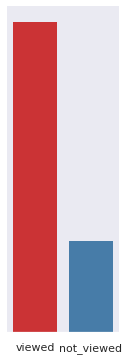

In [ ]:
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(['viewed', 'not_viewed'], model_output['logits'].softmax(1)[0].tolist(), linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])

In [ ]:
#@title Get raw attention mat + residual coonections

res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

# np.set_printoptions(threshold=np.inf)
# print(res_adj_mat[24][25])
# print(res_labels_to_index)

path = f'{mat_data_save_dir}/{index_key}_raw_attention.json'
data_dic = save_datas(mat=res_att_mat, sentence=sentence, path=path)



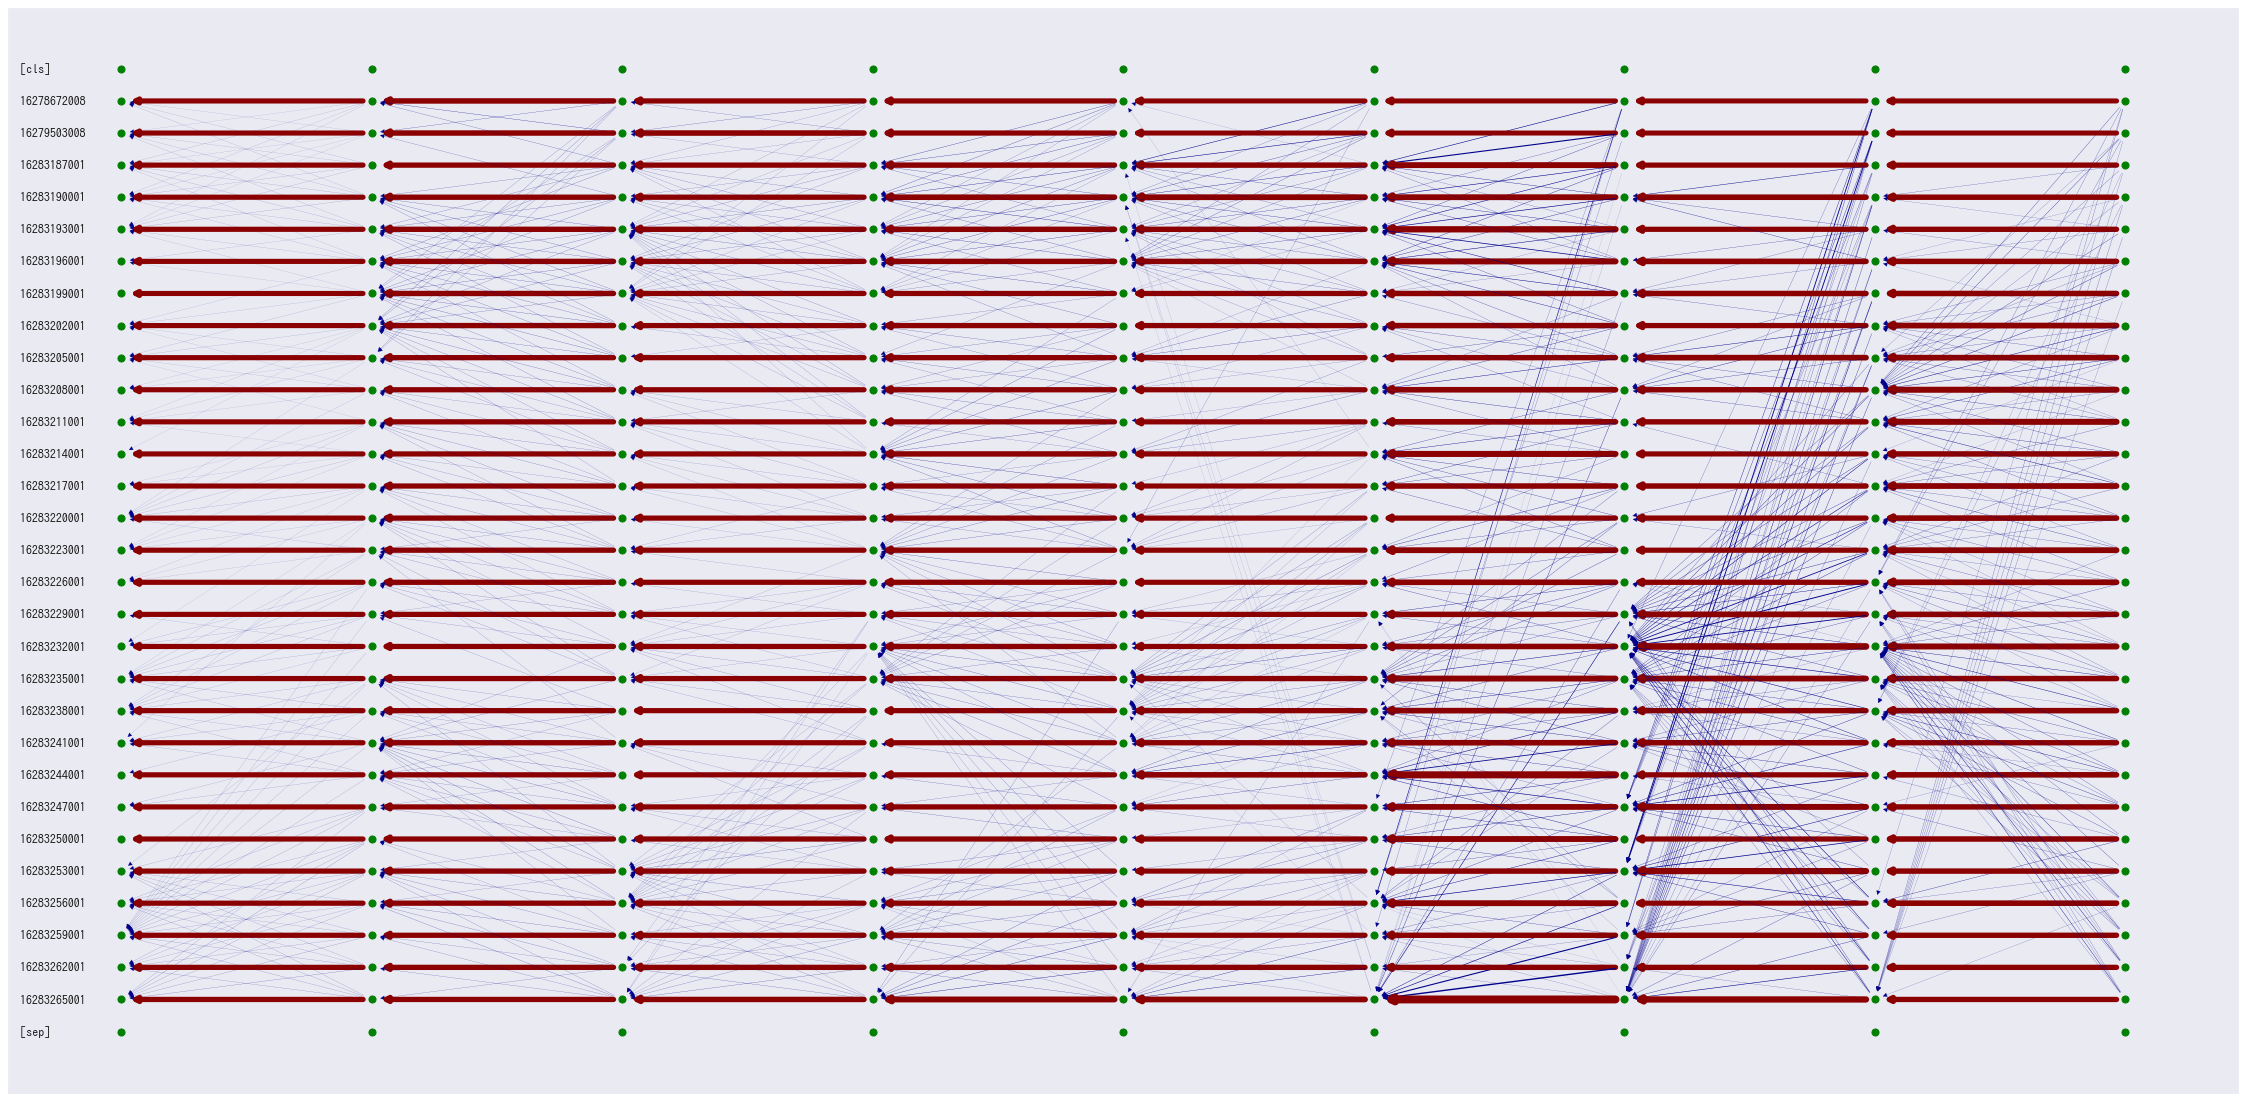

In [ ]:
#@title plot the attention graph
plt.figure(figsize=(40,20))
res_G = draw_attention_graph(res_adj_mat, res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
# plt.savefig(f'{images_save_dir}/{index_key}_raw_attention_graph.png', format='png', transparent=True, dpi=360, bbox_inches='tight')


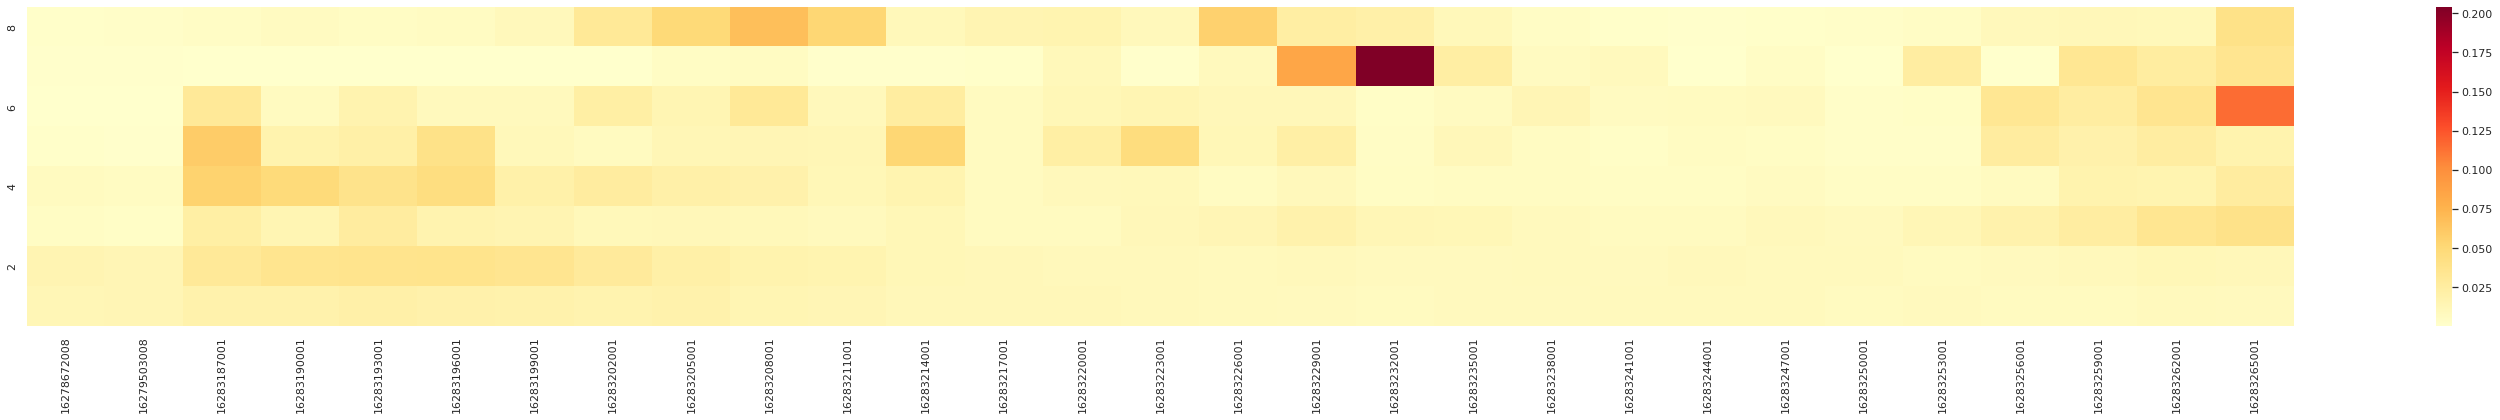

In [ ]:
#@title Plot contrastive heatmap
plt.figure(1,figsize=(40,6))
t_pos = tuple(i for i in range(1,len(tokens)-1))
if 'tv_map' in globals():
    _sentence = ''
    for word in sentence.split():
        _sentence += ' ' + tv_map.get(word, '').replace(' ', '')
    ax = plot_attention_heatmap(res_att_mat, 0, t_positions=t_pos, sentence=_sentence)
else:
    plot_attention_heatmap(res_att_mat, 0, t_positions=t_pos, sentence=sentence)


plt.tight_layout()
# plt.savefig(f'{images_save_dir}/{index_key}_raw_attention_heatmap.png', format='png', transparent=True, dpi=360, bbox_inches='tight')


In [ ]:
#@title Compute attention rollout

joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)


path = f'{mat_data_save_dir}/{index_key}_attention_rollout.json'
data_dic = save_datas(mat=joint_attentions, sentence=sentence, path=path)



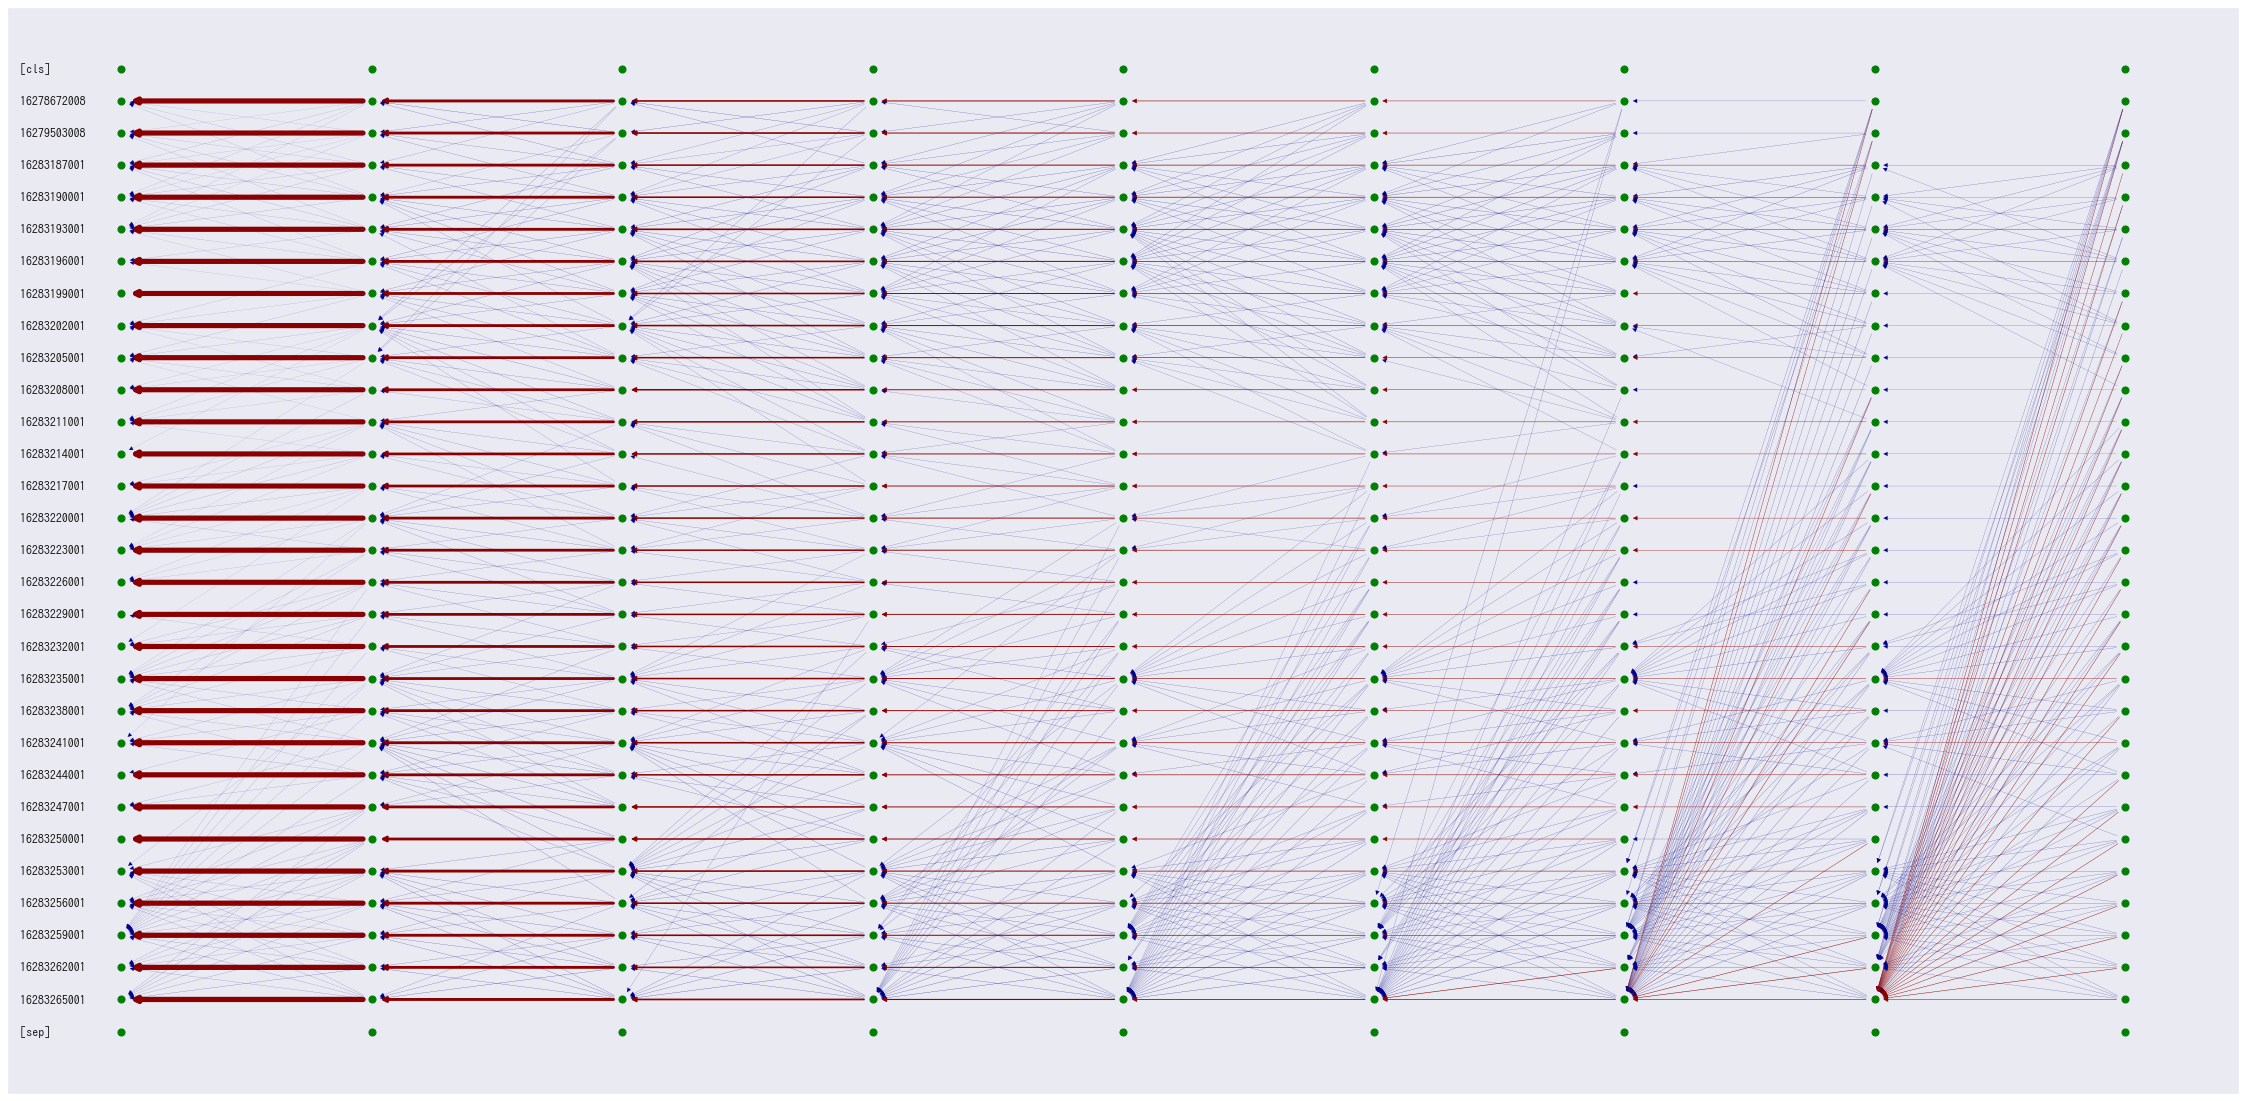

In [ ]:
#@title Draw attention rollout graph
plt.clf()
plt.close()
plt.figure(figsize=(40,20))
G = draw_attention_graph(joint_att_adjmat, joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
# plt.savefig(f'{images_save_dir}/{index_key}_attention_rollout_graph.png', format='png', dpi=360, bbox_inches='tight')


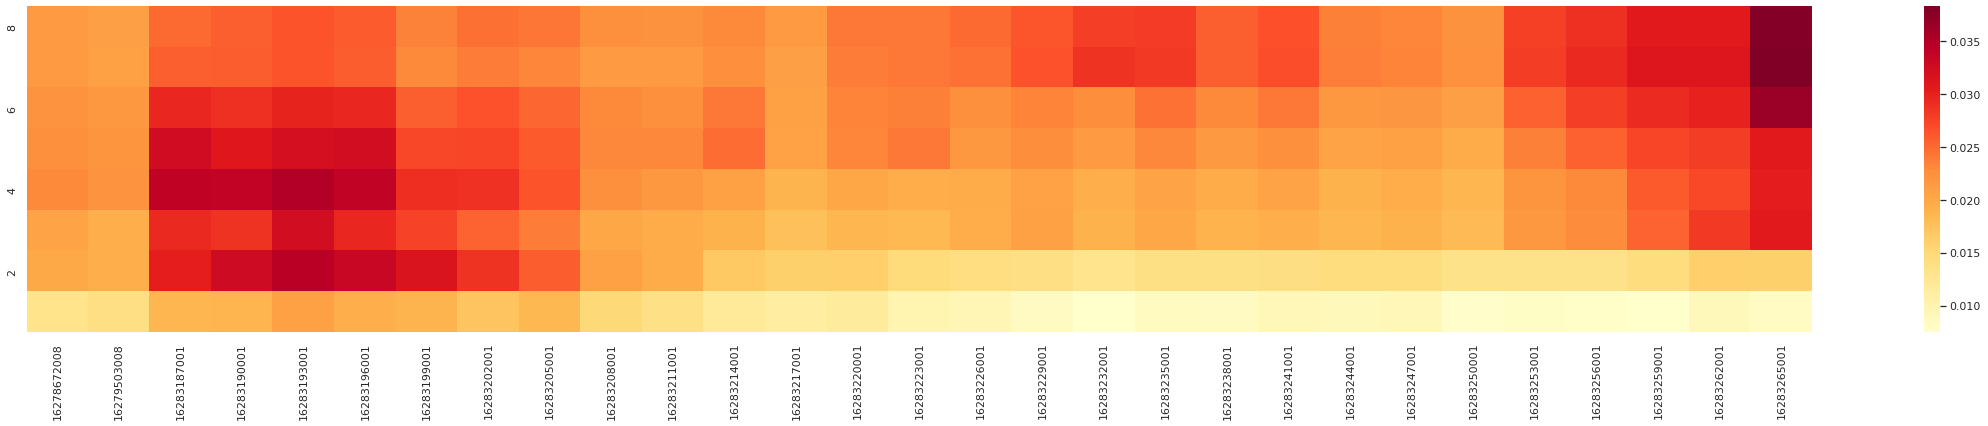

In [ ]:
#@title Plot contrastive heatmap
plt.figure(1,figsize=(40,6))
t_pos = tuple(i for i in range(1,len(tokens)-1))
plot_attention_heatmap(joint_attentions, 0, t_positions=t_pos, sentence=sentence)
# plt.savefig(f'{images_save_dir}/{index_key}_attention_rollout_heatmap.png', format='png', dpi=360, bbox_inches='tight')


In [ ]:
#@title Compute attention flow (this will take quite some time to compute).

output_nodes = []
input_nodes = []
# for key in res_labels_to_index:
#     if 'L24' in key:
#         output_nodes.append(key)
#     if res_labels_to_index[key] < attentions_mat.shape[-1]:
#         input_nodes.append(key)

# flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])


In [ ]:
#@title Draw attention flow graph
# plt.figure(figsize=(40,20))
# flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
# plt.savefig(f'{images_save_dir}/{index_key}_attention_flow_graph.png', format='png', dpi=360, bbox_inches='tight')


In [ ]:
#@title Plot contrastive heatmap
# flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])
# plt.figure(1,figsize=(20,6))
# t_pos = tuple(i for i in range(1,len(tokens)-1))
# plot_attention_heatmap(flow_att_mat, 0, t_positions=t_pos, sentence=sentence)
# # plt.savefig(f'{images_save_dir}/{index_key}_attention_flow_heatmap.png', format='png', transparent=True, dpi=360, bbox_inches='tight')


# path = f'{mat_data_save_dir}/{index_key}_attention_flow.json'
# data_dic = save_datas(mat=flow_att_mat, sentence=sentence, path=path)



In [ ]:
# @title 全ユーザのグラフを出力

classify_label = "viewed"



for i, index_key in enumerate(users.keys()):
    sentence = users[index_key]
    if i > 9:
      classify_label = "predict_missed"
    elif i > 4:
      classify_label = "not_viewed"

    tokens = ['[cls]', *tokenizer.tokenize(sentence), '[sep]']
    print(f'ユーザ一覧: {index_keys}')
    print(f'ユーザ:{index_key}')
    print(f'単語数:{len(tokens)}')
    print(f'文章:{tokens}')
    tf_input_ids = tokenizer.encode(sentence)
    print(f'トークン:{tokenizer.decode(tf_input_ids)}')
    input_ids = torch.tensor([tf_input_ids])
    model_output = model(input_ids)
    all_hidden_states, all_attentions  = model_output['hidden_states'], model_output['attentions']

    _attentions = [att.detach().numpy() for att in all_attentions]
    attentions_mat = np.asarray(_attentions)[:,0]
    # model_output['logits'][0]
    print(attentions_mat.shape)
    # model_output['logits'][0].tolist()

    #@title Get raw attention mat + residual coonections

    res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
    res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
    res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

    res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

    # np.set_printoptions(threshold=np.inf)
    # print(res_adj_mat[24][25])
    # print(res_labels_to_index)

    path = f'{mat_data_save_dir}/{index_key}_raw_attention.json'
    save_datas(mat=res_att_mat, sentence=sentence, path=path)

    #@title plot the attention graph
    image_dir = os.path.join(images_save_dir, classify_label, 'raw')
    os.makedirs(image_dir, exist_ok=True)

    plt.figure(figsize=(40,20))
    res_G = draw_attention_graph(res_adj_mat, res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
    plt.savefig(f'{image_dir}/{index_key}_raw_attention_graph.png', format='png', transparent=True, dpi=360, bbox_inches='tight')

    #@title Plot contrastive heatmap
    plt.figure(figsize=(40,6))
    t_pos = tuple(i for i in range(1,len(tokens)-1))
    if 'tv_map' in globals():
        _sentence = ''
        for word in sentence.split():
            _sentence += ' ' + tv_map.get(word, '').replace(' ', '')
        ax = plot_attention_heatmap(res_att_mat, 0, t_positions=t_pos, sentence=_sentence)
    else:
        plot_attention_heatmap(res_att_mat, 0, t_positions=t_pos, sentence=sentence)


    plt.tight_layout()
    plt.savefig(f'{image_dir}/{index_key}_raw_attention_heatmap.png', format='png', transparent=True, dpi=360, bbox_inches='tight')

    #@title Compute attention rollout

    joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
    joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)


    path = f'{mat_data_save_dir}/{index_key}_attention_rollout.json'
    save_datas(mat=joint_attentions, sentence=sentence, path=path)

    #@title Draw attention rollout graph
    image_dir = os.path.join(images_save_dir, classify_label, 'rollout')
    os.makedirs(image_dir, exist_ok=True)

    plt.clf()
    plt.close()
    plt.figure(figsize=(40,20))
    G = draw_attention_graph(joint_att_adjmat, joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
    plt.savefig(f'{image_dir}/{index_key}_attention_rollout_graph.png', format='png', dpi=360, bbox_inches='tight')

    #@title Plot contrastive heatmap
    plt.figure(figsize=(40,6))
    t_pos = tuple(i for i in range(1,len(tokens)-1))
    plot_attention_heatmap(joint_attentions, 0, t_positions=t_pos, sentence=sentence)
    plt.savefig(f'{image_dir}/{index_key}_attention_rollout_heatmap.png', format='png', dpi=360, bbox_inches='tight')

    #@title Compute attention flow (this will take quite some time to compute).

    # output_nodes = []
    # input_nodes = []
    # for key in res_labels_to_index:
    #     if 'L24' in key:
    #         output_nodes.append(key)
    #     if res_labels_to_index[key] < attentions_mat.shape[-1]:
    #         input_nodes.append(key)

    # flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])

    # #@title Draw attention flow graph
    # image_dir = os.path.join(images_save_dir, classify_label, 'flow')
    # os.makedirs(image_dir, exist_ok=True)

    # plt.figure(figsize=(40,20))
    # flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
    # plt.savefig(f'{image_dir}/{index_key}_attention_flow_graph.png', format='png', dpi=360, bbox_inches='tight')

    # #@title Plot contrastive heatmap
    # flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

    # path = f'{mat_data_save_dir}/{index_key}_attention_flow.json'
    # save_datas(mat=flow_att_mat, sentence=sentence, path=path)

    # plt.figure(figsize=(20,6))
    # t_pos = tuple(i for i in range(1,len(tokens)-1))
    # plot_attention_heatmap(flow_att_mat, 0, t_positions=t_pos, sentence=sentence)
    # plt.savefig(f'{image_dir}/{index_key}_attention_flow_heatmap.png', format='png', transparent=True, dpi=360, bbox_inches='tight')






ユーザ一覧: ['L1913', 'L7467', 'L8906', 'L11106', 'L19724', 'L20242', 'L25594', 'L27437', 'L27438', 'L34319', 'L34425', 'L34908', 'L34984', 'L35591', 'L38626', 'L40108', 'L40900', 'L48262', 'L48905', 'L51042', 'L56141', 'L58392', 'L61970', 'L62943', 'L64446', 'L69035', 'L69106', 'L69341', 'L71012', 'L76219', 'L79439', 'L79627', 'L80528', 'L86853', 'L92712', 'L94441', 'L94442', 'L94443', 'L94559', 'L98836', 'L99780', 'L100794', 'L100931', 'L101321', 'L101565', 'L101833', 'L101834', 'L113884', 'L114711', 'L115065', 'L16', 'L17', 'L46', 'L119', 'L121', 'L132', 'L137', 'L138', 'L147', 'L172', 'L173', 'L175', 'L182', 'L201', 'L257', 'L318', 'L341', 'L357', 'L364', 'L365', 'L368', 'L394', 'L411', 'L414', 'L426', 'L445', 'L449', 'L500', 'L508', 'L514', 'L543', 'L545', 'L548', 'L552', 'L571', 'L581', 'L587', 'L588', 'L589', 'L596', 'L597', 'L604', 'L611', 'L616', 'L649', 'L671', 'L681', 'L682', 'L690', 'L714', 'L275', 'L337', 'L379', 'L386', 'L531', 'L664', 'L723', 'L742', 'L816', 'L874', 'L1031', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ユーザ一覧: ['L1913', 'L7467', 'L8906', 'L11106', 'L19724', 'L20242', 'L25594', 'L27437', 'L27438', 'L34319', 'L34425', 'L34908', 'L34984', 'L35591', 'L38626', 'L40108', 'L40900', 'L48262', 'L48905', 'L51042', 'L56141', 'L58392', 'L61970', 'L62943', 'L64446', 'L69035', 'L69106', 'L69341', 'L71012', 'L76219', 'L79439', 'L79627', 'L80528', 'L86853', 'L92712', 'L94441', 'L94442', 'L94443', 'L94559', 'L98836', 'L99780', 'L100794', 'L100931', 'L101321', 'L101565', 'L101833', 'L101834', 'L113884', 'L114711', 'L115065', 'L16', 'L17', 'L46', 'L119', 'L121', 'L132', 'L137', 'L138', 'L147', 'L172', 'L173', 'L175', 'L182', 'L201', 'L257', 'L318', 'L341', 'L357', 'L364', 'L365', 'L368', 'L394', 'L411', 'L414', 'L426', 'L445', 'L449', 'L500', 'L508', 'L514', 'L543', 'L545', 'L548', 'L552', 'L571', 'L581', 'L587', 'L588', 'L589', 'L596', 'L597', 'L604', 'L611', 'L616', 'L649', 'L671', 'L681', 'L682', 'L690', 'L714', 'L275', 'L337', 'L379', 'L386', 'L531', 'L664', 'L723', 'L742', 'L816', 'L874', 'L1031', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

ユーザ一覧: ['L1913', 'L7467', 'L8906', 'L11106', 'L19724', 'L20242', 'L25594', 'L27437', 'L27438', 'L34319', 'L34425', 'L34908', 'L34984', 'L35591', 'L38626', 'L40108', 'L40900', 'L48262', 'L48905', 'L51042', 'L56141', 'L58392', 'L61970', 'L62943', 'L64446', 'L69035', 'L69106', 'L69341', 'L71012', 'L76219', 'L79439', 'L79627', 'L80528', 'L86853', 'L92712', 'L94441', 'L94442', 'L94443', 'L94559', 'L98836', 'L99780', 'L100794', 'L100931', 'L101321', 'L101565', 'L101833', 'L101834', 'L113884', 'L114711', 'L115065', 'L16', 'L17', 'L46', 'L119', 'L121', 'L132', 'L137', 'L138', 'L147', 'L172', 'L173', 'L175', 'L182', 'L201', 'L257', 'L318', 'L341', 'L357', 'L364', 'L365', 'L368', 'L394', 'L411', 'L414', 'L426', 'L445', 'L449', 'L500', 'L508', 'L514', 'L543', 'L545', 'L548', 'L552', 'L571', 'L581', 'L587', 'L588', 'L589', 'L596', 'L597', 'L604', 'L611', 'L616', 'L649', 'L671', 'L681', 'L682', 'L690', 'L714', 'L275', 'L337', 'L379', 'L386', 'L531', 'L664', 'L723', 'L742', 'L816', 'L874', 'L1031', 